In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
sb.set_style("white")

/tmp/6932980.1.all.q/ipykernel_208130/597048702.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
os.getcwd()

'/net/mraid14/export/tgdata/users/markusm/exe-gastrulation/notebooks/Bmp4/Markus'

In [3]:
os.chdir("../../../")

In [4]:
os.getcwd()

'/net/mraid14/export/tgdata/users/markusm/exe-gastrulation'

In [5]:
raw = ad.read_h5ad('mc2/bmp4_ko_cells.h5ad')

In [6]:
mc.ut.set_name(raw, 'bmp4_ko')
print(raw.shape)

(28032, 30324)


In [7]:
excluded_gene_names = ["Neat1", "Xist", "Malat1", "AK140265","AK018753","AK163440","DQ539915","AK131586","AK131579","AK142750","X57780","GU332589","BC071253"]
excluded_gene_patterns = [
#     '^IGJ', '^IGH', '^IGK', '^IGL', 'MT-*', "^MTMR*", '^MTRNR*', '^MTND*',  
    'ERCC*', 
#     'hotspot*', 
#     'LOC*'
]

In [8]:
%%time
mc.pl.analyze_clean_genes(raw,
                          excluded_gene_names=excluded_gene_names,
                          excluded_gene_patterns=excluded_gene_patterns,
                          random_seed=123456)

set bmp4_ko.var[properly_sampled_gene]: 21742 true (71.7%) out of 30324 bools
set bmp4_ko.var[excluded_gene]: 113 true (0.3726%) out of 30324 bools
set bmp4_ko.var[noisy_lonely_gene]: 0 true (0%) out of 30324 bools


CPU times: user 6min 15s, sys: 40 s, total: 6min 55s
Wall time: 14.5 s


In [9]:
%%time
mc.pl.pick_clean_genes(raw)

set bmp4_ko.var[clean_gene]: 21633 true (71.34%) out of 30324 bools


CPU times: user 2.22 ms, sys: 2.02 ms, total: 4.24 ms
Wall time: 3.16 ms


In [10]:
from collections import Counter
Counter(raw.var.clean_gene)

Counter({True: 21633, False: 8691})

In [11]:
%%time
# raw.write('full_embexe.h5ad')
full = raw

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 34.1 µs


<timed exec>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Will exclude 8237 (29.38%) cells with less than 1500 UMIs
Will exclude 725 (2.59%) cells with more than 20000 UMIs
CPU times: user 2.44 s, sys: 2.64 s, total: 5.08 s
Wall time: 617 ms


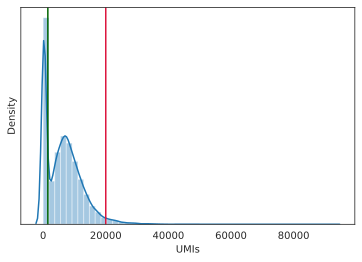

In [12]:
%%time
properly_sampled_min_cell_total = 1500
properly_sampled_max_cell_total = 20000

total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

plot = sb.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

In [13]:
np.median(total_umis_of_cells)

5990.0

<timed exec>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Will exclude 4594 (16.39%) cells with more than 20.00% excluded gene UMIs
CPU times: user 2.59 s, sys: 2.49 s, total: 5.09 s
Wall time: 429 ms


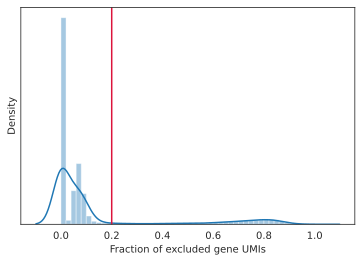

In [14]:
%%time
properly_sampled_max_excluded_genes_fraction = 0.2

excluded_genes_data = mc.tl.filter_data(full, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sb.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

In [15]:
%%time
mc.pl.analyze_clean_cells(
    full,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

set bmp4_ko.obs[properly_sampled_cell]: 18922 true (67.5%) out of 28032 bools


CPU times: user 283 ms, sys: 8.69 ms, total: 292 ms
Wall time: 37.5 ms


In [16]:
%%time
mc.pl.pick_clean_cells(full)

set bmp4_ko.obs[clean_cell]: 18922 true (67.5%) out of 28032 bools


CPU times: user 7.61 ms, sys: 1.11 ms, total: 8.72 ms
Wall time: 7.22 ms


In [48]:
%%time
clean = mc.pl.extract_clean_data(full)

set bmp4_ko.clean.obs[full_cell_index]: 18922 int64s
set bmp4_ko.clean.var[full_gene_index]: 21633 int64s


CPU times: user 601 ms, sys: 773 ms, total: 1.37 s
Wall time: 1.37 s


In [49]:
%%time
suspect_gene_names = [
    "A2m", "AA465934;AI450353", "AK021383;Prrc2c", "AK033756;Rab3il1", "AK087340;Eif3a", "AK156288;Tpd52", "AK158346;Snrpd2", "AK164737;Ell2", "AK165270;Rbm25", "AK196308;Tuba1b", "AK202516;P4hb", "AK204572;Eef1a1", "Acsl3;Utp14b", "Alad", "Aldoa", "Ankrd11", "Arl6ip1", "Atp5j", "Atrx", "Bst2", "Calr", "Cap1", "Cbx7", "Ccdc155", "Ccnb1", "Ccne1", "Cenpe", "Cenpf", "Chchd10", "Chd4;Mir7045", "Cox7b", "Cox7c", "Cox8a", "Cpox", "Csf2rb;Mir7676-2", "Ddx21", "Dek", "Dmkn", "Dsg2", "Eif5a", "Eif5b", "Erv3", "F11r", "Fblim1", "Fech", "Glrx5", "Gm12338", "Gm15772;Rpl26", "Gm1821", "Gprc5a", "Gpx1", "Gse1", "Hbb-b2", "Hdac6", "Hdgf", "Hist1h1a", "Hist1h1b", "Hist1h1c", "Hist1h1d", "Hist1h1e", "Hist1h2ae", "Hmmr", "Hsp90aa1", "Hsp90ab1", "Hsp90b1", "Hspa5", "Hspa8", "Hspe1", "Il1r2", "Isyna1", "Kif20b", "Kmt2a", "Ldha", "Ly6a", "Ly6c1", "Manf", "Mbnl1", "Mir6236", "Mir7079;Rpl13", "Mki67", "Msh6", "Naca", "Nasp", "Ncl", "Npm1", "Pdia6", "Pfn1", "Pkm", "Plekhf2", "Pnpo", "Prc1", "Prdx2", "Prmt1", "Prpf40a", "Psip1", "Psmb10", "Ptma", "Pttg1", "Rab15", "Rell1", "Rn45s", "Rpl14-ps1", "Rpl22l1", "Rpl23", "Rpl32", "Rpl37", "Rpl38", "Rpl41", "Rpl7", "Rplp0", "Rplp1", "Rps10", "Rps11", "Rps14", "Rps15", "Rps15a-ps6", "Rps18", "Rps2", "Rps20", "Rps21", "Rps25", "Rps26", "Rps27l", "Rps4l", "Rps5", "Rpsa", "Rrm2", "S100a4", "S100a8", "Slc14a1", "Slc16a3", "Slc6a12", "Smc4", "Smox", "Soat1", "Son", "Spint1", "Spns2", "Srrm2", 
#     "Ssx2ip", 
    "Tac2", "Tfrc", "Tjp2", "Tmem14c", "Top1", "Top2a", "Tpr", "Tubb5", "Ubb", "Ube2c", "Ung", "Hspb1", "Hspb8"
    
#     Hbb-bs, # 1e-3
    "Hbb-y",  # 2e-2
#     Hbb-b2, # 2e-4
    "Hba-a2", # 1e-2
    "Hba-x",  # 4e-2
    "Hbb-bh1",# 1e-1
]
suspect_gene_patterns = [ 'MCM[0-9]', 'SMC[0-9]', 'IFI.*', 'Hist1*.', 'HSP90.+' , 'COX.+']
# suspect_gene_patterns = ['MCM[0-9]', 'SMC[0-9]', 'IFI.*', 'Hist1*.', 'HSP*' , 'COX.+']
suspect_genes_mask = mc.tl.find_named_genes(clean, names=suspect_gene_names,
                                            patterns=suspect_gene_patterns)
suspect_gene_names = sorted(clean.var_names[suspect_genes_mask])

CPU times: user 17.1 ms, sys: 1.02 ms, total: 18.2 ms
Wall time: 16.5 ms


In [50]:
%%time
mc.pl.relate_genes(clean, random_seed=123456, 
                   genes_similarity_method="pearson")#, min_genes_of_modules=)
# method in ("pearson", "repeated_pearson", "logistics", "logistics_pearson")

set bmp4_ko.clean.var[related_genes_module]: 19548 outliers (90.36%) out of 21633 int32 elements with 144 groups with mean size 14.48
set bmp4_ko.clean.varp[related_genes_similarity]: csr_matrix 21633 X 21633 float32s (4347225 > 0)


CPU times: user 48.7 s, sys: 4.37 s, total: 53 s
Wall time: 6.1 s


In [51]:
module_of_genes = clean.var['related_genes_module']
suspect_gene_modules = np.unique(module_of_genes[suspect_genes_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
print(suspect_gene_modules)

[ 13  33  35  39  48  65  68  72  73  83  84  88  92  93  95  97 101 114
 116 121 126 127 128 133 134 136 138 140 141 142 143]


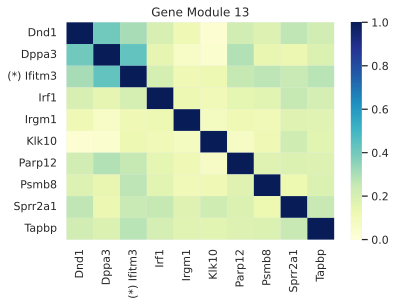

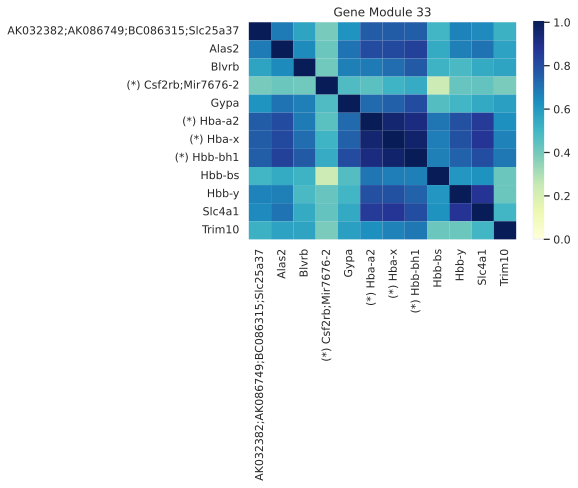

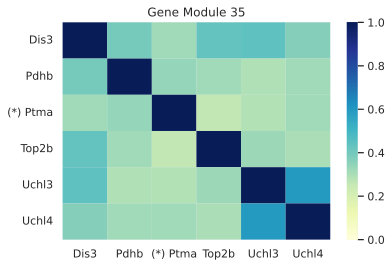

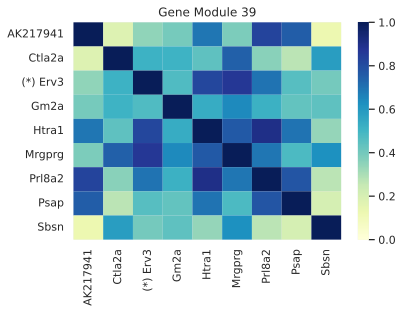

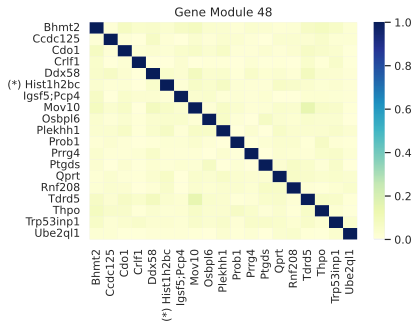

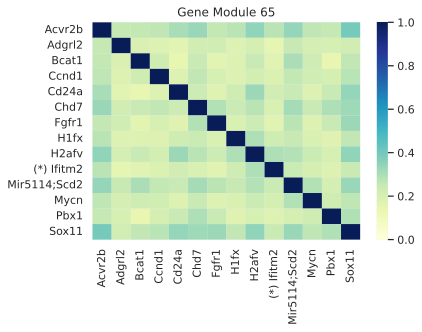

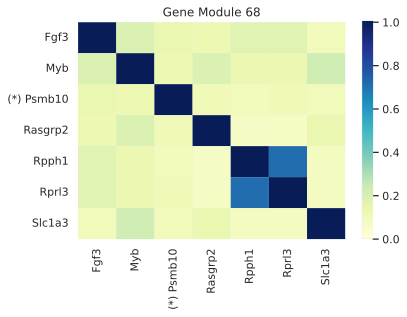

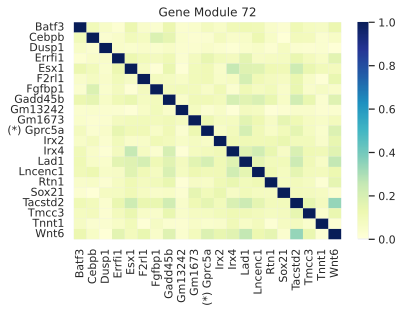

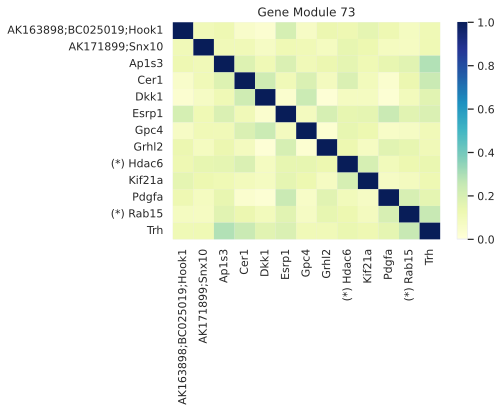

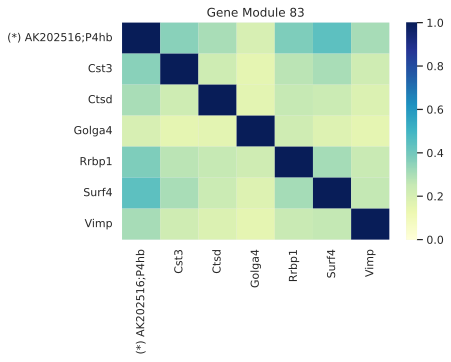

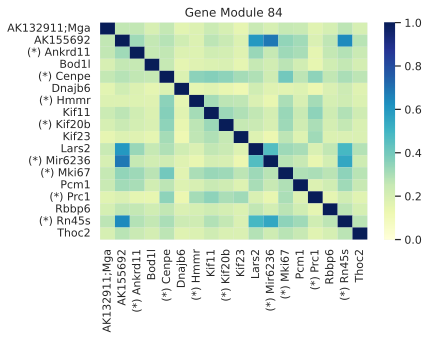

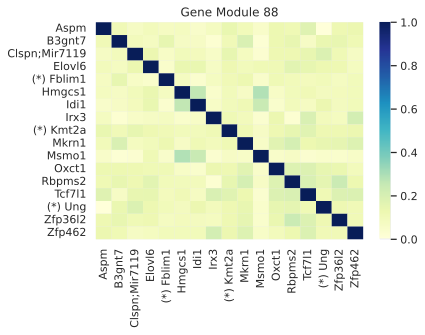

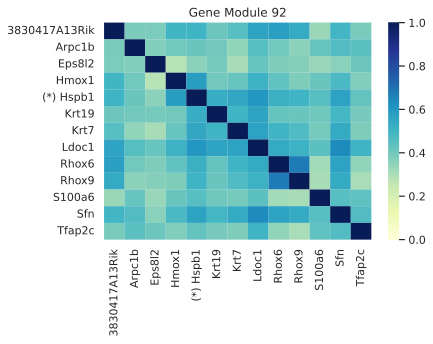

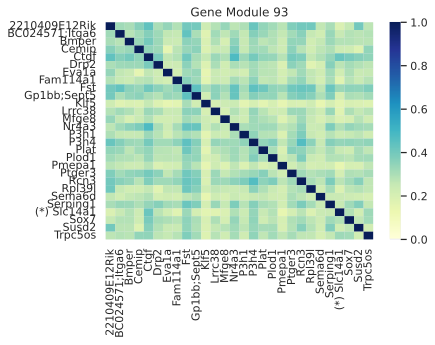

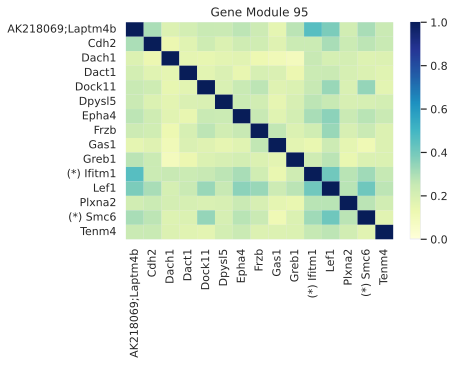

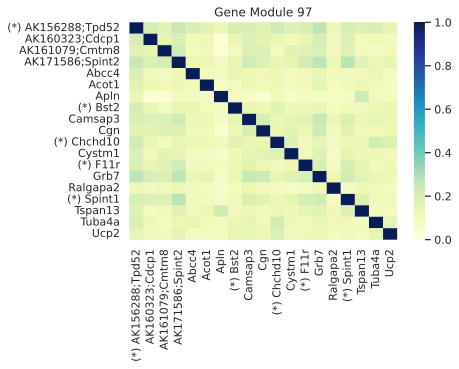

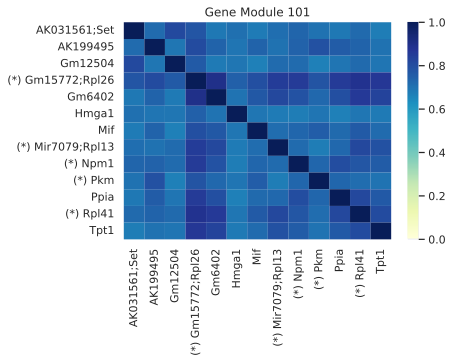

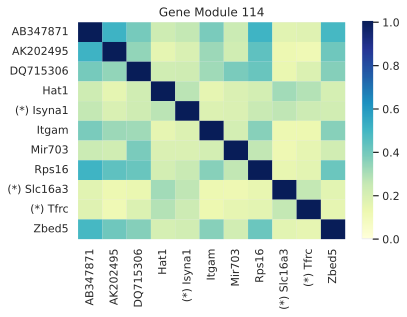

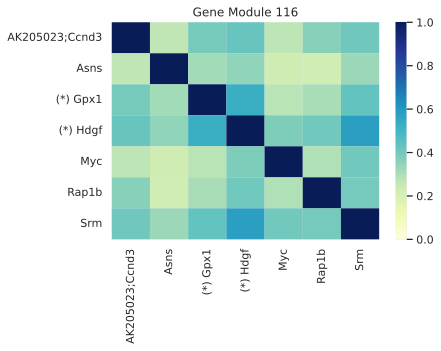

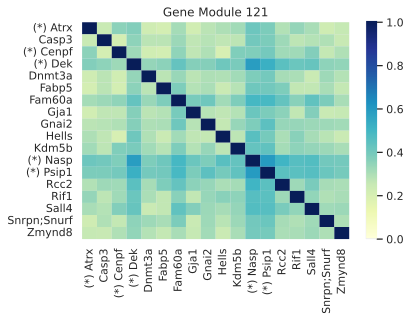

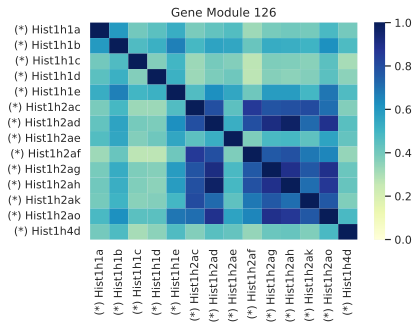

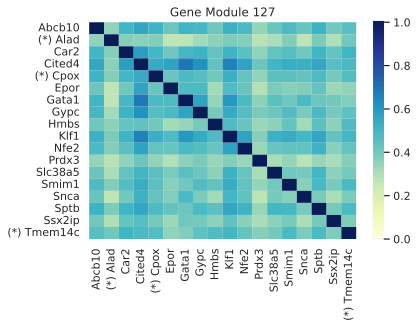

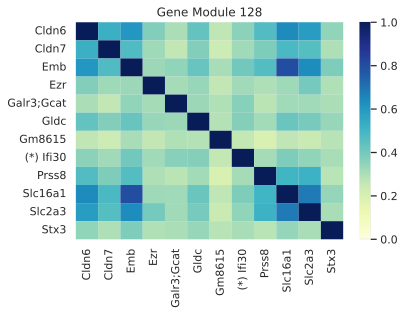

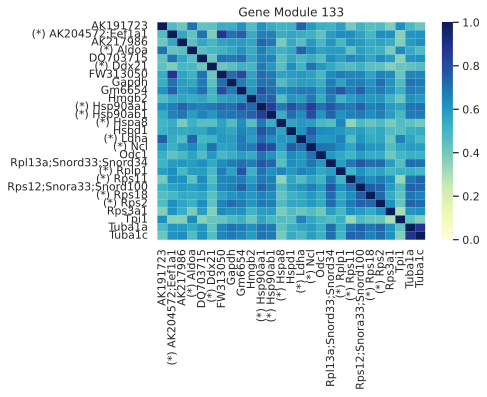

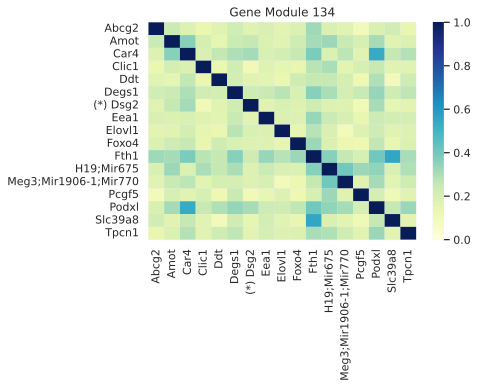

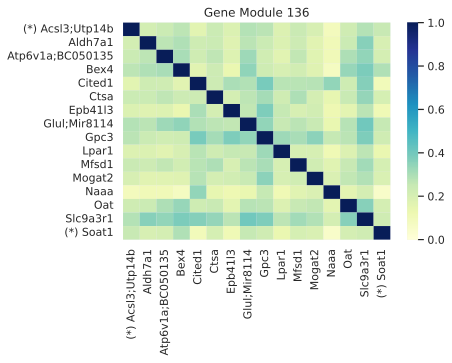

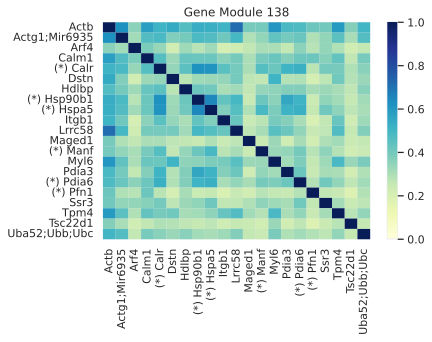

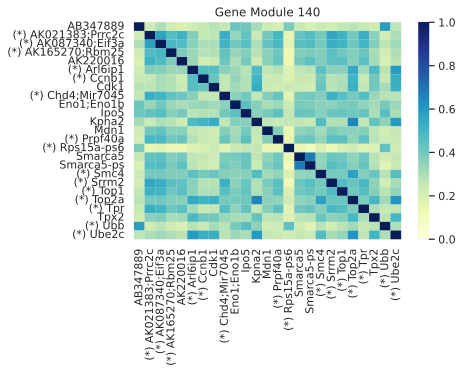

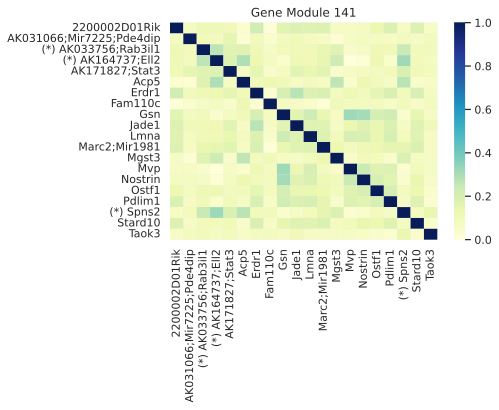

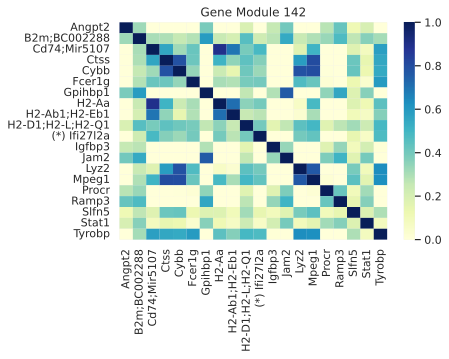

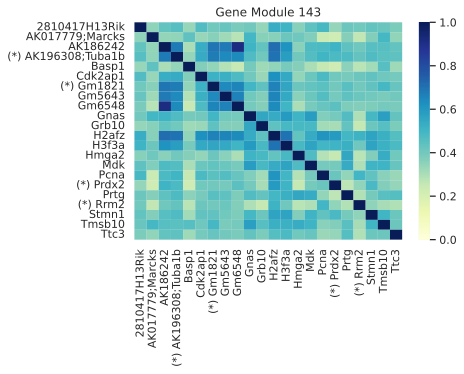

In [52]:
similarity_of_genes = mc.ut.get_vv_frame(clean, 'related_genes_similarity')
for gene_module in suspect_gene_modules:
    module_genes_mask = module_of_genes == gene_module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    similarity_of_module.index = \
    similarity_of_module.columns = [
        '(*) ' + name if name in suspect_gene_names else name
        for name in similarity_of_module.index
    ]
    ax = plt.axes()
    sb.heatmap(similarity_of_module, vmin=0, vmax=1, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu")
    ax.set_title(f'Gene Module {gene_module}')
#     plt.savefig('embexe_new_{}.png'.format(gene_module), bbox_inches='tight')
    plt.show()

In [53]:
clean.var_names

Index(['0610005C13Rik', '0610007P14Rik', '0610009B22Rik', '0610009L18Rik',
       '0610009O20Rik', '0610010B08Rik', '0610010B08Rik;Gm4724',
       '0610010F05Rik', '0610010K14Rik;Rnasek', '0610011F06Rik',
       ...
       'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a;AK172452;Raly',
       'abParts;AK002875;AK037822;AK135975;AK156292;Igha;Igh-A (1g2);Ighd;Ighe;Ighg1;Ighg2c;M13680;M25573;M36767;mFLJ00385;Mir7094-2;V00821',
       'abParts;AK036494;M34473', 'l7Rn6'],
      dtype='object', length=21633)

In [54]:
%%time
forbidden_genes_mask = suspect_genes_mask

for gene_module in [84,101,126,133,138,140,143]:
    module_genes_mask = module_of_genes == gene_module
    forbidden_genes_mask |= module_genes_mask
# forbidden_genes_mask['HES1'] = False
forbidden_gene_names = sorted(clean.var_names[forbidden_genes_mask])
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

351
2810417H13Rik A2m AA465934;AI450353 AB347889 AK017779;Marcks AK021383;Prrc2c AK031561;Set AK033756;Rab3il1 AK087340;Eif3a AK132911;Mga AK155692 AK156288;Tpd52 AK158346;Snrpd2 AK164737;Ell2 AK165270;Rbm25 AK186242 AK191723 AK196308;Tuba1b AK199495 AK202516;P4hb AK204572;Eef1a1 AK217986 AK220016 Acsl3;Utp14b Actb Actg1;Mir6935 Alad Aldoa Ankrd11 Arf4 Arl6ip1 Atp5j Atrx Basp1 Bod1l Bst2 Calm1 Calr Cap1 Cbx7 Ccdc155 Ccnb1 Ccne1 Cdk1 Cdk2ap1 Cenpe Cenpf Chchd10 Chd4;Mir7045 Cox10 Cox11 Cox14 Cox15 Cox17 Cox18 Cox19 Cox20 Cox4i1 Cox4i2 Cox5a Cox5b Cox6a1 Cox6a2 Cox6b1 Cox6b2 Cox6c Cox7a1 Cox7a2 Cox7a2l Cox7b Cox7b2 Cox7c Cox8a Cox8c Cpox Csf2rb;Mir7676-2 DQ703715 Ddx21 Dek Dmkn Dnajb6 Dsg2 Dstn Eif5a Eif5b Eno1;Eno1b Erv3 F11r FW313050 Fblim1 Fech Gapdh Glrx5 Gm12338 Gm12504 Gm15772;Rpl26 Gm1821 Gm5643 Gm6402 Gm6548 Gm6654 Gnas Gprc5a Gpx1 Grb10 Gse1 H2afz H3f3a Hba-a2 Hba-x Hbb-b2 Hbb-bh1 Hdac6 Hdgf Hdlbp Hist1h1a Hist1h1b Hist1h1c Hist1h1d Hist1h1e Hist1h1t Hist1h2aa Hist1h2ab Hist1h2a

In [55]:
max_parallel_piles = mc.pl.guess_max_parallel_piles(clean)
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

85


In [25]:
mc.pl.divide_and_conquer_pipeline?

In [56]:
%%time
mc.pl.divide_and_conquer_pipeline(clean,
                                  dissolve_min_robust_size_factor=0.4,
                                  dissolve_min_metacell_cells= 10,
                                  lateral_gene_names=forbidden_gene_names,
                                  target_metacell_size=150000,
                                  random_seed=123)

set bmp4_ko.clean.var[rare_gene]: 0 true (0%) out of 21633 bools
set bmp4_ko.clean.var[rare_gene_module]: 21633 int32 elements with all outliers (100%)
set bmp4_ko.clean.obs[cells_rare_gene_module]: 18922 int32 elements with all outliers (100%)
set bmp4_ko.clean.obs[rare_cell]: 0 true (0%) out of 18922 bools
set bmp4_ko.clean.uns[pre_directs]: 3
set bmp4_ko.clean.uns[directs]: 3
set bmp4_ko.clean.var[pre_high_total_gene]: 12188 positive (56.34%) out of 21633 int32s
set bmp4_ko.clean.var[high_total_gene]: 12560 positive (58.06%) out of 21633 int32s
set bmp4_ko.clean.var[pre_high_relative_variance_gene]: 4911 positive (22.7%) out of 21633 int32s
set bmp4_ko.clean.var[high_relative_variance_gene]: 4768 positive (22.04%) out of 21633 int32s
set bmp4_ko.clean.var[lateral_gene]: 351 true (1.623%) out of 21633 bools
set bmp4_ko.clean.var[bystander_gene]: 0 true (0%) out of 21633 bools
set bmp4_ko.clean.var[pre_feature_gene]: 964 positive (4.456%) out of 21633 int32s
set bmp4_ko.clean.var[feat

CPU times: user 1min 25s, sys: 4.76 s, total: 1min 29s
Wall time: 3min 36s


In [57]:
%%time
metacells = mc.pl.collect_metacells(clean, name='metacells')

set bmp4_ko.clean.obs[metacell_name]: 18922 <U8s
set metacells.var[excluded_gene]: 0 true (0%) out of 21633 bools
set metacells.var[clean_gene]: 21633 true (100%) out of 21633 bools
set metacells.var[lateral_gene]: 351 true (1.623%) out of 21633 bools
set metacells.var[bystander_gene]: 0 true (0%) out of 21633 bools
set metacells.var[pre_feature_gene]: 964 positive (4.456%) out of 21633 int32s
set metacells.var[feature_gene]: 1062 positive (4.909%) out of 21633 int32s
set metacells.obs[pile]: 1191 int32s
set metacells.obs[candidate]: 1191 int32s


CPU times: user 2.68 s, sys: 559 ms, total: 3.24 s
Wall time: 3.24 s


In [58]:
metacells.obs_names

Index(['M0.01', 'M1.08', 'M2.08', 'M3.07', 'M4.02', 'M5.08', 'M6.05', 'M7.00',
       'M8.02', 'M9.00',
       ...
       'M1181.06', 'M1182.00', 'M1183.03', 'M1184.09', 'M1185.08', 'M1186.08',
       'M1187.07', 'M1188.09', 'M1189.03', 'M1190.06'],
      dtype='object', length=1191)

In [52]:
clean.obs.metacell?

In [59]:
#clean.obs.metacell >= 0
clean2 = mc.ut.slice(clean, obs=clean.obs.metacell >= 0)

In [60]:
min(clean2.obs.groupby('metacell').aggregate('count')['properly_sampled_cell'])

10

In [61]:
%%time
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=2.0, random_seed=42)

set metacells.var[top_feature_gene]: 455 true (2.103%) out of 21633 bools
set metacells.obsp[obs_balanced_ranks]: 14650 nonzero (1.033%) out of 1418481 elements
set metacells.obsp[obs_pruned_ranks]: 4786 nonzero (0.3374%) out of 1418481 elements
set metacells.obsp[obs_outgoing_weights]: 4786 nonzero (0.3374%) out of 1418481 elements
set metacells.obsp[umap_distances]: csr_matrix 1191 X 1191 float32s (1417290 > 0)
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set metacells.obs[umap_x]: 1191 float32s
set metacells.obs[umap_y]: 1191 float32s


CPU times: user 18.7 s, sys: 6.72 s, total: 25.5 s
Wall time: 5.85 s


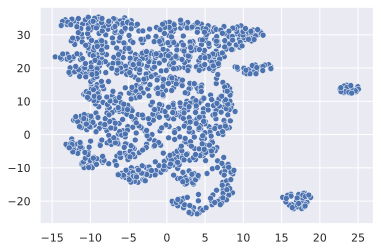

In [62]:
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sb.scatterplot(x=umap_x, y=umap_y)

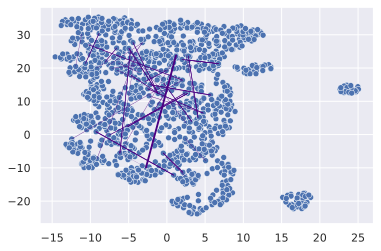

CPU times: user 459 ms, sys: 53 ms, total: 512 ms
Wall time: 532 ms


In [63]:
%%time
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, 'obs_outgoing_weights'))
min_long_edge_size = 4
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y)
for (source_index, target_index, weight) \
        in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

In [64]:
clean.write('mc2/clean_bmp4_ko.h5ad')
metacells.write('mc2/metacells_bmp4_ko.h5ad')
# del metacells.uns['__name__']
# metacells.write('for_seurat_ss5.h5ad')

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'metacell_name' as categorical


In [65]:
data = mc.pl.compute_for_mcview(adata=clean, gdata=metacells)

set metacells.var[significant_gene]: 8324 true (38.48%) out of 21633 bools
set metacells.var[top_feature_gene]: 436 true (2.015%) out of 21633 bools
set metacells.obsp[obs_balanced_ranks]: 14670 nonzero (1.034%) out of 1418481 elements
set metacells.obsp[obs_pruned_ranks]: 4787 nonzero (0.3375%) out of 1418481 elements
set metacells.obsp[obs_outgoing_weights]: 4787 nonzero (0.3375%) out of 1418481 elements
set metacells.obsp[umap_distances]: csr_matrix 1191 X 1191 float32s (1417290 > 0)
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set metacells.obs[umap_x]: 1191 float32s
set metacells.obs[umap_y]: 1191 float32s
set metacells.var[top_feature_gene]: 436 true (2.015%) out of 21633 bools
set metacells.obsp[obs_balanced_ranks]: 14670 nonzero (1.034%) out of 1418481 elements
set metacells.obsp[obs_pruned_

In [66]:
data.write('mc2/outliers_bmp4_ko.h5ad')
clean.write('clean_bmp4_ko.h5ad')
metacells.write('metacells_bmp4_ko.h5ad')

In [67]:
adata = ad.read_h5ad("/home/ofirr/amos_ofirr/mm_atlas_scdb/mm_atlas.h5ad")

In [68]:
qdata = metacells

In [69]:
mc.ut.set_name(adata, "atlas.metacells")
mc.ut.set_name(qdata, "query.metacells")

In [70]:
# weights, qdata = mc.pl.projection_pipeline(adata=adata, qdata=qdata, reproducible=True)
weights, qdata = mc.pl.projection_pipeline(adata=adata, qdata=qdata, project_corrections=False, reproducible=True, project_min_similar_essential_genes_fraction=None)

set query.metacells.common.obs[full_metacell_index_of_qdata]: 1191 int64s
set query.metacells.common.var[full_gene_index_of_qdata]: 21216 int64s
set query.metacells.common.obs[common_cell_index_of_qdata]: 1191 int64s
set query.metacells.common.var[common_gene_index_of_qdata]: 21216 int64s
set query.metacells.common.var[correction_factor]: 21216 float32s
set query.metacells.common.var[atlas_gene]: 21216 true (100%) out of 21216 bools
set query.metacells.common.var[atlas_significant_gene]: 7112 true (33.52%) out of 21216 bools
set query.metacells.common.var[ignored_gene]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.included.layers[projected]: ndarray 1191 X 7112 float32s
set query.metacells.common.included.layers[projected_fold]: ndarray 1191 X 7112 float32s
set query.metacells.common.included.var[projected_correlation]: 7112 float32s
set query.metacells.common.included.var[correlated_gene]: 2839 true (39.92%) out of 7112 bools
set query.metacells.common.included.va

set query.metacells.common.Early nascent mesoderm.var[ignored_gene_of_Early nascent mesoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Neural plate boundary.var[ignored_gene_of_Neural plate boundary]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Paraxial mesoderm.var[ignored_gene_of_Paraxial mesoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Gut.var[ignored_gene_of_Gut]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Definitive ectoderm.var[ignored_gene_of_Definitive ectoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Caudal mesoderm.var[ignored_gene_of_Caudal mesoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.EPC progenitors.included.layers[projected]: ndarray 2 X 7112 float32s
set query.metacells.common.EPC progenitors.included.layers[projected_fold]: ndarray 2 X 7112 float32s
set query.metacells.common.EPC progenitors.included.var[misfit_gene

set query.metacells.common.Node/Notochord.included.obs[similar]: 15 true (100%) out of 15 bools
set query.metacells.common.Erythroid 2.included.layers[projected]: ndarray 18 X 7112 float32s
set query.metacells.common.Erythroid 2.included.layers[projected_fold]: ndarray 18 X 7112 float32s
set query.metacells.common.Erythroid 2.included.var[misfit_gene_of_Erythroid 2]: 1 true (0.01406%) out of 7112 bools
set query.metacells.common.Erythroid 2.included.var[ignored_gene_of_Erythroid 2]: 1 true (0.01406%) out of 7112 bools
set query.metacells.common.Somitic mesoderm.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Somitic mesoderm.var[ignored_gene_of_Somitic mesoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Caudal neural plate.included.layers[projected]: ndarray 16 X 7112 float32s
set query.metacells.common.Caudal neural plate.included.layers[projected_fold]: ndarray 16 X 7112 float32s
set query.metacells.common.Caudal neural plate.includ

set query.metacells.common.ExE visceral endoderm.included.var[misfit_gene_of_ExE visceral endoderm]: 0 true (0%) out of 7112 bools
set query.metacells.common.ExE visceral endoderm.included.obs[dissimilar_genes_count]: 10 positive (52.63%) out of 19 int64s
set query.metacells.common.ExE visceral endoderm.included.obs[similar]: 19 true (100%) out of 19 bools
set query.metacells.common.Tail bud - neural.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Tail bud - neural.var[ignored_gene_of_Tail bud - neural]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.TGC progenitors.included.layers[projected]: ndarray 2 X 7112 float32s
set query.metacells.common.TGC progenitors.included.layers[projected_fold]: ndarray 2 X 7112 float32s
set query.metacells.common.TGC progenitors.included.var[misfit_gene_of_TGC progenitors]: 3 true (0.04218%) out of 7112 bools
set query.metacells.common.TGC progenitors.included.var[ignored_gene_of_TGC progenitors]: 3 true (0.

set query.metacells.common.Surface ectoderm.included.layers[projected_fold]: ndarray 12 X 7112 float32s
set query.metacells.common.Surface ectoderm.included.var[misfit_gene_of_Surface ectoderm]: 1 true (0.01406%) out of 7112 bools
set query.metacells.common.Surface ectoderm.included.var[ignored_gene_of_Surface ectoderm]: 1 true (0.01406%) out of 7112 bools
set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.layers[projected]: ndarray 41 X 7112 float32s
set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.layers[projected_fold]: ndarray 41 X 7112 float32s
set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.var[misfit_gene_of_Forebrain/Midbrain/Hindbrain]: 0 true (0%) out of 7112 bools
set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.obs[dissimilar_genes_count]: 4 positive (9.756%) out of 41 int64s
set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.obs[similar]: 41 true (100%) out of 41 bools
set query.metacells.common.P

set query.metacells.common.Allantois.included.var[misfit_gene_of_Allantois]: 0 true (0%) out of 7110 bools
set query.metacells.common.Allantois.included.obs[dissimilar_genes_count]: 6 positive (20.69%) out of 29 int64s
set query.metacells.common.Allantois.included.obs[similar]: 29 true (100%) out of 29 bools
set query.metacells.common.Tail bud - neural.included.layers[projected]: ndarray 31 X 7112 float32s
set query.metacells.common.Tail bud - neural.included.layers[projected_fold]: ndarray 31 X 7112 float32s
set query.metacells.common.Tail bud - neural.included.var[misfit_gene_of_Tail bud - neural]: 0 true (0%) out of 7112 bools
set query.metacells.common.Tail bud - neural.included.obs[dissimilar_genes_count]: 7 positive (22.58%) out of 31 int64s
set query.metacells.common.Tail bud - neural.included.obs[similar]: 31 true (100%) out of 31 bools
set query.metacells.common.Amnion/Chorion.included.layers[projected]: ndarray 33 X 7109 float32s
set query.metacells.common.Amnion/Chorion.incl

set query.metacells.common.var[ignored_gene_of_EPC progenitors]: 14105 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Early nascent mesoderm]: 2 true (0.009427%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Early nascent mesoderm]: 14106 true (66.49%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Endothelial cells]: 0 true (0%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Endothelial cells]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Epiblast]: 0 true (0%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Epiblast]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Erythroid 1]: 1 true (0.004713%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Erythroid 1]: 14105 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Erythroid 2]: 1 true (0.004713%) out of 2121

set query.metacells.common.Blood progenitors.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Blood progenitors.var[ignored_gene_of_Blood progenitors]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Caudal mesoderm.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Caudal neural plate.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Erythroid 3.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Caudal mesoderm.var[ignored_gene_of_Caudal mesoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Caudal neural plate.var[ignored_gene_of_Caudal neural plate]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Erythroid 3.var[ignored_gene_of_Erythroid 3]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Neural tube/Floor plate.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.EPC progenitors.var[full

set query.metacells.common.Definitive endoderm.included.layers[projected]: ndarray 3 X 7112 float32s
set query.metacells.common.Definitive endoderm.included.layers[projected_fold]: ndarray 3 X 7112 float32s
set query.metacells.common.Definitive endoderm.included.var[misfit_gene_of_Definitive endoderm]: 3 true (0.04218%) out of 7112 bools
set query.metacells.common.Definitive endoderm.included.var[ignored_gene_of_Definitive endoderm]: 3 true (0.04218%) out of 7112 bools
set query.metacells.common.Anterior Primitive Streak.included.layers[projected]: ndarray 3 X 7112 float32s
set query.metacells.common.Anterior Primitive Streak.included.layers[projected_fold]: ndarray 3 X 7112 float32s
set query.metacells.common.Anterior Primitive Streak.included.var[misfit_gene_of_Anterior Primitive Streak]: 3 true (0.04218%) out of 7112 bools
set query.metacells.common.Anterior Primitive Streak.included.var[ignored_gene_of_Anterior Primitive Streak]: 3 true (0.04218%) out of 7112 bools
set query.metace

set query.metacells.common.Haematoendothelial progenitors.included.obs[similar]: 16 true (94.12%) out of 17 bools
set query.metacells.common.Node/Notochord.included.layers[projected]: ndarray 15 X 7112 float32s
set query.metacells.common.Node/Notochord.included.layers[projected_fold]: ndarray 15 X 7112 float32s
set query.metacells.common.Node/Notochord.included.var[misfit_gene_of_Node/Notochord]: 0 true (0%) out of 7112 bools
set query.metacells.common.Node/Notochord.included.obs[dissimilar_genes_count]: 4 positive (26.67%) out of 15 int64s
set query.metacells.common.Node/Notochord.included.obs[similar]: 15 true (100%) out of 15 bools
set query.metacells.common.Erythroid 2.included.layers[projected]: ndarray 18 X 7112 float32s
set query.metacells.common.Erythroid 2.included.layers[projected_fold]: ndarray 18 X 7112 float32s
set query.metacells.common.Erythroid 2.included.var[misfit_gene_of_Erythroid 2]: 1 true (0.01406%) out of 7112 bools
set query.metacells.common.Erythroid 2.included

set query.metacells.common.SpT-Gly.included.obs[similar]: 1 true (100%) out of 1 bools
set query.metacells.common.Visceral endoderm.var[full_metacell_index_of_qdata]: 21216 int64s
set query.metacells.common.Visceral endoderm.var[ignored_gene_of_Visceral endoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.Rostral mesoderm.included.layers[projected]: ndarray 14 X 7112 float32s
set query.metacells.common.Rostral mesoderm.included.layers[projected_fold]: ndarray 14 X 7112 float32s
set query.metacells.common.Rostral mesoderm.included.var[misfit_gene_of_Rostral mesoderm]: 2 true (0.02812%) out of 7112 bools
set query.metacells.common.Rostral mesoderm.included.var[ignored_gene_of_Rostral mesoderm]: 2 true (0.02812%) out of 7112 bools
set query.metacells.common.ExE visceral endoderm.included.layers[projected]: ndarray 19 X 7112 float32s
set query.metacells.common.ExE visceral endoderm.included.layers[projected_fold]: ndarray 19 X 7112 float32s
set query.metacells.commo

set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.obs[dissimilar_genes_count]: 4 positive (9.756%) out of 41 int64s
set query.metacells.common.Forebrain/Midbrain/Hindbrain.included.obs[similar]: 41 true (100%) out of 41 bools
set query.metacells.common.Primitive streak.included.layers[projected]: ndarray 11 X 7110 float32s
set query.metacells.common.Primitive streak.included.layers[projected_fold]: ndarray 11 X 7110 float32s
set query.metacells.common.Primitive streak.included.var[misfit_gene_of_Primitive streak]: 0 true (0%) out of 7110 bools
set query.metacells.common.Erythroid 1.included.layers[projected]: ndarray 19 X 7111 float32s
set query.metacells.common.Primitive streak.included.obs[dissimilar_genes_count]: 0 positive (0%) out of 11 int64s
set query.metacells.common.Primitive streak.included.obs[similar]: 11 true (100%) out of 11 bools
set query.metacells.common.Erythroid 1.included.layers[projected_fold]: ndarray 19 X 7111 float32s
set query.metacells.common.Er

set query.metacells.common.Allantois.included.obs[dissimilar_genes_count]: 6 positive (20%) out of 30 int64s
set query.metacells.common.Allantois.included.obs[similar]: 30 true (100%) out of 30 bools
set query.metacells.common.ExE mesoderm.included.layers[projected]: ndarray 32 X 7110 float32s
set query.metacells.common.ExE mesoderm.included.layers[projected_fold]: ndarray 32 X 7110 float32s
set query.metacells.common.ExE mesoderm.included.var[misfit_gene_of_ExE mesoderm]: 0 true (0%) out of 7110 bools
set query.metacells.common.ExE mesoderm.included.obs[dissimilar_genes_count]: 12 positive (37.5%) out of 32 int64s
set query.metacells.common.ExE mesoderm.included.obs[similar]: 32 true (100%) out of 32 bools
set query.metacells.common.Epiblast.included.layers[projected]: ndarray 50 X 7112 float32s
set query.metacells.common.Epiblast.included.layers[projected_fold]: ndarray 50 X 7112 float32s
set query.metacells.common.Amnion/Chorion.included.layers[projected]: ndarray 33 X 7109 float32s

set query.metacells.common.var[misfit_gene_of_ExE mesoderm]: 2 true (0.009427%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_ExE mesoderm]: 14106 true (66.49%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_ExE visceral endoderm]: 0 true (0%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_ExE visceral endoderm]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Forebrain/Midbrain/Hindbrain]: 0 true (0%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Forebrain/Midbrain/Hindbrain]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Gut]: 0 true (0%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Gut]: 14104 true (66.48%) out of 21216 bools
set query.metacells.common.var[misfit_gene_of_Haematoendothelial progenitors]: 0 true (0%) out of 21216 bools
set query.metacells.common.var[ignored_gene_of_Haematoendothelial progenitors]:

set query.metacells.common.dissimilar.single.obs[projected_type]: [ Cardiopharyngeal mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_secondary_type]: [ ExE mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_type]: [ Paraxial mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_secondary_type]: [ ExE mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_secondary_type]: [ Somitic mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_secondary_type]: [ Amnion/Chorion progenitor ]
set query.metacells.common.dissimilar.single.obs[projected_secondary_type]: [ ExE mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_type]: [ Cardiopharyngeal mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_type]: [ Cardiopharyngeal mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_type]: [ Erythroid 2 ]
set query.metacells.common.dissimilar.single.obs[projected_t

set query.metacells.common.dissimilar.single.layers[projected]: ndarray 1 X 7112 float32s
set query.metacells.common.dissimilar.single.layers[projected_fold]: ndarray 1 X 7112 float32s
set query.metacells.common.dissimilar.single.obs[dissimilar_genes_count]: 1 positive (100%) out of 1 int64s
set query.metacells.common.dissimilar.single.obs[similar]: 1 true (100%) out of 1 bools
set query.metacells.common.dissimilar.single.layers[projected]: ndarray 1 X 7112 float32s
set query.metacells.common.dissimilar.single.layers[projected_fold]: ndarray 1 X 7112 float32s
set query.metacells.common.dissimilar.single.obs[dissimilar_genes_count]: 1 positive (100%) out of 1 int64s
set query.metacells.common.dissimilar.single.obs[similar]: 1 true (100%) out of 1 bools
set query.metacells.common.dissimilar.single.obs[projected_secondary_type]: [ ExE mesoderm ]
set query.metacells.common.dissimilar.single.obs[projected_type]: [ Cardiopharyngeal mesoderm ]
set query.metacells.common.dissimilar.single.laye

In [71]:
with open("mc2/bmp4_ko.query.atlas.weights.csv", "w") as file:
    file.write("query,atlas,weight\n")
    for query_index, atlas_index, in zip(*weights.nonzero()):
        weight = weights[query_index, atlas_index]
        file.write(f"{query_index},{atlas_index},{weight}\n")

In [72]:
qdata.write('mc2/bmp4_ko_projected.h5ad')

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'projected_type' as categorical
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'projected_secondary_type' as categorical


In [46]:
#qdata.obs.index = [i for i,k in enumerate(qdata.obs.index)]

In [85]:
color_sc = pd.read_csv("config/cell_type_colors_mm_embexe_old.tsv", sep="\t")
color_sc = color_sc.set_index("cell_type")

In [103]:
colors_to_add = []
for i in qdata.obs.projected_type.values:
    if i in color_sc.index:
        colors_to_add.append(color_sc.loc[i, "color"])
        
    else:
        colors_to_add.append("gray")

In [104]:
mc.ut.set_o_data(adata=qdata, name="colors", data=colors_to_add)

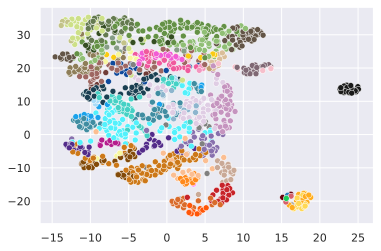

In [106]:
ax = sb.scatterplot(x=umap_x, y=umap_y, c=colors_to_add)


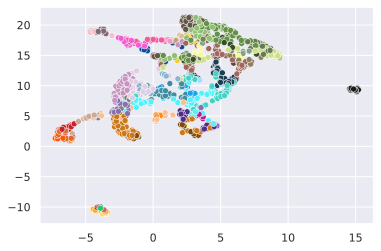

In [108]:
ax = sb.scatterplot(x=mc.ut.get_o_numpy(qdata, 'umap_x'), y=mc.ut.get_o_numpy(qdata, 'umap_y'), c=colors_to_add)


In [ ]:
forbidden_gene_names